### title: "Deduplication of contact information"
#### author: "Rohit Rangarajan"
#### date: "August 28, 2021"

#### To run this notebook
1. Create conda environment
    - conda create --name introhive python=3.7
2. Activate conda environment 
    - conda activate introhive
3. Install packages
    - pip install jupyter 
    - pip install pandas
    - pip install seaborn
    - pip install sklearn
4. Unzip the provided zip file and upload the project into a directory

## 1. Data exploration

#### Import necessary packages

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

#### Read data into pandas dataframe

In [2]:
df = pd.read_csv("../address_data/data/address_matching_data.csv")

#### Total number of records

In [3]:
len(df)

29104

#### Look at the columns in the data
- we have 26 different features

In [4]:
print('Number of columns = ', len(df.columns))
df.columns

Number of columns =  28


Index(['id', 'name_levenshtein_simple', 'name_trigram_simple',
       'name_levenshtein_term', 'name_trigram_term', 'city_levenshtein_simple',
       'city_trigram_simple', 'city_levenshtein_term', 'city_trigram_term',
       'zip_levenshtein_simple', 'zip_trigram_simple', 'zip_levenshtein_term',
       'zip_trigram_term', 'street_levenshtein_simple',
       'street_trigram_simple', 'street_levenshtein_term',
       'street_trigram_term', 'website_levenshtein_simple',
       'website_trigram_simple', 'website_levenshtein_term',
       'website_trigram_term', 'phone_levenshtein', 'phone_trigram',
       'fax_levenshtein', 'fax_trigram', 'street_number_levenshtein',
       'street_number_trigram', 'is_match'],
      dtype='object')

#### Look at top few samples from the data

In [5]:
df.head()

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,website_trigram_simple,website_levenshtein_term,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,is_match
0,0#1,1.000000,1.000000,1.000000,1.000000,?,?,?,?,?,...,?,?,?,?,?,?,?,1.0,1.0,1
1,0#2,0.857143,0.857143,0.894737,0.947368,?,?,?,?,?,...,?,?,?,?,?,?,?,1.0,1.0,1
2,0#3,1.000000,1.000000,1.000000,1.000000,?,?,?,?,?,...,?,?,?,?,?,?,?,1.0,1.0,1
3,4#5,0.857143,0.857143,0.842105,0.833333,1,1,1,1,1,...,?,?,?,0.272727272727,0.0909090936184,?,?,1.0,1.0,1
4,6#7,0.250000,0.000000,0.250000,0.000000,?,?,?,?,?,...,?,?,?,1.0,1.0,?,?,?,?,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29104 entries, 0 to 29103
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          29104 non-null  object 
 1   name_levenshtein_simple     29104 non-null  float64
 2   name_trigram_simple         29104 non-null  float64
 3   name_levenshtein_term       29104 non-null  float64
 4   name_trigram_term           29104 non-null  float64
 5   city_levenshtein_simple     29104 non-null  object 
 6   city_trigram_simple         29104 non-null  object 
 7   city_levenshtein_term       29104 non-null  object 
 8   city_trigram_term           29104 non-null  object 
 9   zip_levenshtein_simple      29104 non-null  object 
 10  zip_trigram_simple          29104 non-null  object 
 11  zip_levenshtein_term        29104 non-null  object 
 12  zip_trigram_term            29104 non-null  object 
 13  street_levenshtein_simple   291

#### Check for NULL values

In [7]:
df.isnull().any()

id                            False
name_levenshtein_simple       False
name_trigram_simple           False
name_levenshtein_term         False
name_trigram_term             False
city_levenshtein_simple       False
city_trigram_simple           False
city_levenshtein_term         False
city_trigram_term             False
zip_levenshtein_simple        False
zip_trigram_simple            False
zip_levenshtein_term          False
zip_trigram_term              False
street_levenshtein_simple     False
street_trigram_simple         False
street_levenshtein_term       False
street_trigram_term           False
website_levenshtein_simple    False
website_trigram_simple        False
website_levenshtein_term      False
website_trigram_term          False
phone_levenshtein             False
phone_trigram                 False
fax_levenshtein               False
fax_trigram                   False
street_number_levenshtein     False
street_number_trigram         False
is_match                    

#### How are the target labels represented?
1 for match and -1 for not a match

In [8]:
df['is_match'].unique()

array([ 1, -1])

#### Determine how many features are missing (marked by ?) 

In [9]:
columns_and_missing_features = []
for column in df.columns:
    columns_and_missing_features.append((column, len(df[df[column]=='?'])))

#### Sort the column names in ascending order of missing features (as you go down the list, you have columns with less information available)

In [10]:
sorted(columns_and_missing_features, key = lambda x: x[1])

[('id', 0),
 ('name_levenshtein_simple', 0),
 ('name_trigram_simple', 0),
 ('name_levenshtein_term', 0),
 ('name_trigram_term', 0),
 ('is_match', 0),
 ('street_number_levenshtein', 8510),
 ('street_number_trigram', 8510),
 ('phone_levenshtein', 17475),
 ('phone_trigram', 17475),
 ('city_levenshtein_simple', 19198),
 ('city_trigram_simple', 19198),
 ('city_levenshtein_term', 19198),
 ('city_trigram_term', 19198),
 ('street_levenshtein_simple', 20928),
 ('street_trigram_simple', 20928),
 ('street_levenshtein_term', 20928),
 ('street_trigram_term', 20928),
 ('zip_levenshtein_simple', 21657),
 ('zip_trigram_simple', 21657),
 ('zip_levenshtein_term', 21657),
 ('zip_trigram_term', 21657),
 ('website_levenshtein_simple', 27095),
 ('website_trigram_simple', 27095),
 ('website_levenshtein_term', 27095),
 ('website_trigram_term', 27095),
 ('fax_levenshtein', 28679),
 ('fax_trigram', 28679)]

#### Count number of samples for both target labels 
- we have an imbalanced dataset

In [11]:
print('Number of samples with matching contacts =', len(df[df['is_match'] == 1]))

Number of samples with matching contacts = 23793


In [12]:
print('Number of samples with not matching contacts =', len(df[df['is_match'] == -1]))

Number of samples with not matching contacts = 5311


#### Feature analysis using Pair plot

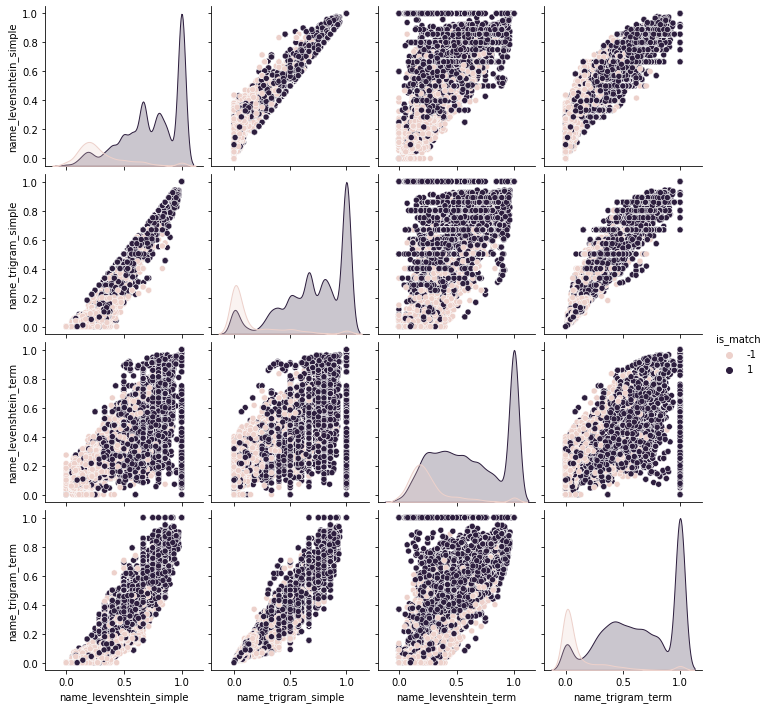

In [13]:
n = df.shape[0]
sns.pairplot(
    df[['name_levenshtein_simple', 'name_trigram_simple', 
        'name_levenshtein_term', 'name_trigram_term', 'is_match']][0:n], 
    hue='is_match', 
    vars=['name_levenshtein_simple', 'name_trigram_simple', 'name_levenshtein_term', 'name_trigram_term'])
plt.show()

#### Observations from the data:
1. Not all pairs of contacts in the data have been analysed by the intern
3. Measures of distance used:
    1. Levenshtein
    2. Trigram
4. We do not have access to actual values of zip, phone, address, etc. to compute missing features, or for determining other new features based on textual similarity
5. There are a lot of missing features (marked by ?), we need to handle those
5. The 4 columns do not have any missing features at all
    - name_levenshtein_simple
    - name_trigram_simple 
    - name_levenshtein_term
    - name_trigram_term

#### Business objectives and constraints:
1. company wants to remove near-duplicate records which were not removed in initial sweep

2. input for model: a pair of contact details
   
   output: match or not (1 or -1)
    
    - This is a binary classification problem
    
3. Given business metric:
    metric = (TPR + 2*TNR) / 3
    
    - For a good classifier, both TPR and TNR should be high. 
    - We do not worry about TNR and FNR in this problem.
    - Hence, higher the metric value, better the performance of our classifier
    
4. Based on problem description, there are no specific latency constraints


## 2. Modelling approach

- Given the amount of data that we are provided with, I would start by building a binary classifier using <b>Random Forest<b>

#### Prepare data in training format for sklearn

In [14]:
X = df.drop(['id', 'is_match'], axis=1)
Y = np.array(df['is_match'])

In [15]:
print(X.shape)
print(Y.shape)

(29104, 26)
(29104,)


#### Handle missing values
- we use a simple mean imputer for now

In [16]:
X = X.replace('?', np.nan) # replace ? with np.nan

X = X.apply(pd.to_numeric) # convert all columns to float since we have some columns with Object type

imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [17]:
print(X.shape)
print(Y.shape)
print(type(X))
print(type(Y))

(29104, 26)
(29104,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#### Train and Test split
- We must use stratified split since we have an imbalanced dataset and we would want to have same ratio of both target labels in train and test set

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

In [19]:
print('Number of 1 in test ' + str(len([elem for elem in Y_test if elem==1])))
print('Number of -1 in test ' + str(len([elem for elem in Y_test if elem==-1])))
print('Number of 1 in train ' + str(len([elem for elem in Y_train if elem==1])))
print('Number of -1 in train ' + str(len([elem for elem in Y_train if elem==-1])))
print("Notice that the ratio of 1 and -1 is same in train and test sets, ie. 4.48")
print('Total training data = ' + str(X_train.shape[0]))
print('Total test data = ' + str(X_test.shape[0]))

Number of 1 in test 4759
Number of -1 in test 1062
Number of 1 in train 19034
Number of -1 in train 4249
Notice that the ratio of 1 and -1 is same in train and test sets, ie. 4.48
Total training data = 23283
Total test data = 5821


#### Calculate feature importance from train set using Random Forest Classifier

Feature: 0, Score: 0.10375
Feature: 1, Score: 0.17560
Feature: 2, Score: 0.06364
Feature: 3, Score: 0.15814
Feature: 4, Score: 0.00784
Feature: 5, Score: 0.00825
Feature: 6, Score: 0.00413
Feature: 7, Score: 0.00404
Feature: 8, Score: 0.00366
Feature: 9, Score: 0.00509
Feature: 10, Score: 0.00339
Feature: 11, Score: 0.00464
Feature: 12, Score: 0.03994
Feature: 13, Score: 0.04381
Feature: 14, Score: 0.02273
Feature: 15, Score: 0.06084
Feature: 16, Score: 0.00121
Feature: 17, Score: 0.00140
Feature: 18, Score: 0.00133
Feature: 19, Score: 0.00127
Feature: 20, Score: 0.07132
Feature: 21, Score: 0.04793
Feature: 22, Score: 0.00101
Feature: 23, Score: 0.00116
Feature: 24, Score: 0.08724
Feature: 25, Score: 0.07664


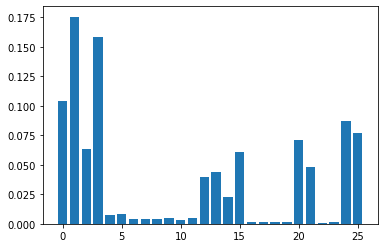

In [20]:
# define the model
model = RandomForestClassifier(random_state=42) # define random state for reproducibility

# fit the model
model.fit(X_train, Y_train)

# get importance
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

#### Parameters for hyperparameter tuning of Random Forest

In [21]:
print('Parameters currently in use:\n')
model.get_params()

Parameters currently in use:



{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### Let us work with the following most important hyperparameters:
    - n_estimators = number of trees in the foreset
    - max_features = max number of features considered for splitting a node
    - max_depth = max number of levels in each decision tree
    - min_samples_split = min number of data points placed in a node before the node is split
    - min_samples_leaf = min number of data points allowed in a leaf node
    - bootstrap = method for sampling data points (with or without replacement)
    
#### We are going to use Sklearn's GridSearchCV for hyperparameter tuning and coming up with best trained model

In [26]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [25,35],
    'max_features': [15,20],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10],
    'n_estimators': [200, 400]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)  # we use 10-fold cross validation

# Fit the grid search to the training data
grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 2 folds for each of 32 candidates, totalling 64 fits


KeyboardInterrupt: 

## 3. Performance analysis

#### Define method to evaluate performance of model using the given business metrc
    - Input: model, input_features, gold_labels
    - Output:  (TPR + 2*TNR) / 3

In [ ]:
def evaluate(model_to_evaluate, features, gold_labels):
    predictions = model_to_evaluate.predict(features)
    
    tn, fp, fn, tp = confusion_matrix(gold_labels, predictions).ravel()
    
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    
    return (tpr + 2*tnr) / 3

#### Plot the confusion matrix and evaluate the best model obtained from hyperparameter tuning

In [ ]:
plot_confusion_matrix(best_model, X_test, Y_test)
print("Performance of model using given business metric = " + str(evaluate(best_model, X_test, Y_test)))

## 4. Conclusions
- We were able to come up with Random Forest Classifier that obtains very good performance on the unseen test set based on the business-defined performance metric
- The model can be saved to disk and just loaded for future inferences
- Random Forest is expensive to train, in terms of training time complexity when performing hyperparameter tuning, but quite fast during inference

##  5. Potential improvements
1. Use only the most important features based on feature importance, instead of using all features
2. Check performance of models using other metrics such as Log loss, ROC curve, etc.
3. If you have access to original textual data
    - Extract other features using semantic textual similarity, fuzzy matching using FuzzyWuzzy library, etc.
4. Collect more data and create balanced dataset 
5. With existing dataset, perform oversampling and undersampling before training
6. Experiment with other classifiers like SVM, Decision Tree, Logistic Regression, etc.
7. Detect and remove outliers (potentially using local outlier factor) before training the ML model
8. Try other imputation techniques to handle missing values in dataset